Using GPU !
开始生成测试数据
生成测试数据消耗时间 t =  37.60624027252197
stpe = 0


epoch: [4/5]: 100%|██████████| 647/647 [00:13<00:00, 47.85it/s]


stpe = 1


epoch: [4/5]: 100%|██████████| 671/671 [00:13<00:00, 49.78it/s]


stpe = 2


epoch: [4/5]: 100%|██████████| 638/638 [00:13<00:00, 48.25it/s]


best_epoch=10


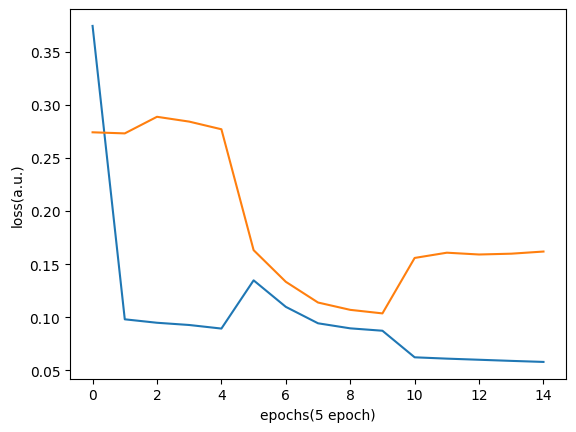

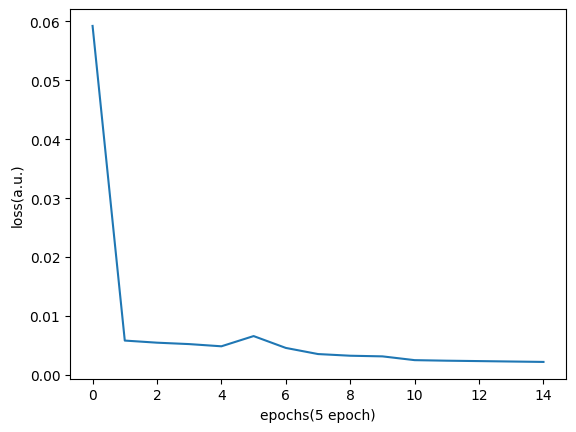

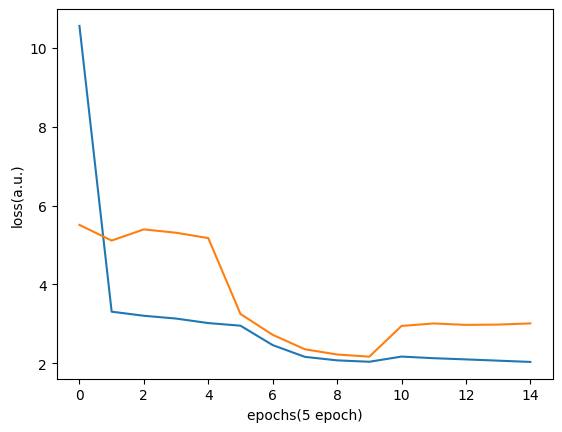

In [9]:
import gc
import os
import torch
from model import FCNN
from torch import nn
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xarray as xr
T1 = time.time()

# 数据读取
from netCDF4 import Dataset

path = r'E:\zjy\shuju\data20240219'
#oco_path = r'F:\zjy\shuju\down\down'
oco_path = r'E:\zjy\shuju\data20240219\down'
tcco2_path = r'E:\zjy\shuju\data20240219\down_cams'
sp_path = r'E:\zjy\shuju\data20240219\down_sp'
d2m_path = r'E:\zjy\shuju\data20240219\down_d2m'
u10_path = r'E:\zjy\shuju\data20240219\down_u10'
v10_path = r'E:\zjy\shuju\data20240219\down_v10'

# 创建需要年份 
# year_list = [2016,2017,2018,2019,2020]
day_list = [0,366,365,365,365,366]
mounth = [0,31,28,31,30,31,30,31,31,30,31,30,31]
# 创建oco文件列表
oco_filelist = os.listdir(oco_path)
oco_year = []
oco_day = []
for filess in oco_filelist:
    years = int('20' + filess[11:13])
    mounths = int(filess[13:15])
    days = sum(day_list[0:years-2015]) + sum(mounth[0:mounths]) + int(filess[15:17])
    if (years%4 == 0 and mounths>2):# 闰年情况
        days = days + 1
    oco_year.append(years)
    oco_day.append(days)
# 数据量过大需要分批读取训练 
split_num = 50 # 分100批
sample_times = len(oco_day)//split_num

# 设置随机种子
random_seed = 2024  
np.random.seed(random_seed)  
random_index = [i for i in range(len(oco_day))]
np.random.shuffle(random_index)

train_day = []
train_year = []
train_filelist = []

for read_batch in range(0,split_num-1):# 取最后一部分做测试集

    oco_day_batch = np.array(oco_day)[random_index[read_batch * sample_times:(read_batch + 1) * sample_times]]
    oco_year_batch = np.array(oco_year)[random_index[read_batch * sample_times:(read_batch + 1) * sample_times]]
    oco_filelist_batch = np.array(oco_filelist)[random_index[read_batch * sample_times:(read_batch + 1) * sample_times]]

    train_day.append(oco_day_batch)
    train_year.append(oco_year_batch)
    train_filelist.append(oco_filelist_batch)

test_day = np.array(oco_day)[random_index[(read_batch + 1) * sample_times:-1]]   
test_year = np.array(oco_year)[random_index[(read_batch + 1) * sample_times:-1]]  
test_filelist = np.array(oco_filelist)[random_index[(read_batch + 1) * sample_times:-1]]


def data_generate(oco_filelist_batch,oco_day_batch,oco_year_batch):

    # xco2数据读取处理
    for days in range(len(oco_filelist_batch)):# #######以ocoxco2作为label，其他数据与它对齐
        #print(days)
        t = time.time()
        path_1 = oco_path + '\\' + oco_filelist_batch[days]

        oco = xr.open_dataset(path_1)
        xco2 = oco.xco2.values
        lon_xco2 = oco.longitude.values
        lat_xco2 = oco.latitude.values
        # 筛选高质量数据
        quality_flag = oco.xco2_quality_flag.values
        high_quality_index = np.where(quality_flag == 0)[0]
        xco2 = xco2[high_quality_index]
        lon_xco2 = np.around(lon_xco2[high_quality_index],1)
        lat_xco2 = np.around(lat_xco2[high_quality_index],1)

        # 排除lon = 180.0的数据（气象数据里没有这个点）
        excil = np.where(lon_xco2 != 180)[0]
        lon_xco2 = lon_xco2[excil]
        lat_xco2 = lat_xco2[excil]

        # 数据预处理，删除xco2重复点位的数据，并生成pos_index和:用于
        label_pos = np.hstack((lon_xco2.reshape(-1,1), lat_xco2.reshape(-1,1)))
        new_pos = np.unique(label_pos, axis=0)# position
        pos_index = np.unique(label_pos, axis=0 , return_index=True)[1]
        label_xco2 = xco2[pos_index]# label
        # 生成时间和日期特征
        #print([oco_year_batch[days]])
        #print([oco_day_batch[days]])
        years = np.array([(oco_year_batch[days] - 2000) / 10]*len(pos_index)).reshape(-1,1)

        for months in day_list:
            if (oco_day_batch[days]-months)>0:
                oco_day_batch[days] = oco_day_batch[days]-months

        date = np.array([oco_day_batch[days] / 360 ]*len(pos_index)).reshape(-1,1)# 360是他的归一化系数
        #print('xco2数据处理',time.time() - t) 

        # tcco2数据读取处理
        tcco2_path_day = tcco2_path + '\\' + str(days) + '_tcco2.nc'
        #tcco2 = Dataset(tcco2_path_day, mode='r', format='NETCDF4').variables['tcco2'][:,:].astype(np.float32)
        tcco2 = xr.open_dataset(tcco2_path_day).tcco2.values.astype(np.float32)
        #tc_lon = np.around(Dataset(tcco2_path_day, mode='r', format='NETCDF4').variables['lon'][:].astype(np.float32)- 180,1).compressed()  # 0-360转-180-180
        tc_lon = np.around(xr.open_dataset(tcco2_path_day).lon.values.astype(np.float32)- 180,1) # 0-360转-180-180
        tc_lat = np.around(np.ceil(10 * xr.open_dataset(tcco2_path_day).lat.values.astype(np.float32))/10,1)
        # 其他气象数据
        sp_path_day = sp_path + '\\' + str(days) + '_sp.nc'
        d2m_path_day = d2m_path + '\\' + str(days) + '_d2m.nc'
        u10_path_day = u10_path + '\\' + str(days) + '_u10.nc'
        v10_path_day = v10_path + '\\' + str(days) + '_v10.nc'

        sp = xr.open_dataset(sp_path_day).sp.values.astype(np.float32)
        d2m = xr.open_dataset(d2m_path_day).d2m.values.astype(np.float32)
        u10 = xr.open_dataset(u10_path_day).u10.values.astype(np.float32)
        v10 = xr.open_dataset(v10_path_day).v10.values.astype(np.float32)
        # print('气象数据读取',time.time() - t) 

        # 按照label xco2 对齐数据
        new_tc = []
        new_sp = []
        new_d2m = []
        new_u10 = []
        new_v10 = []

        for i in range(len(new_pos)): 
            x = np.where(tc_lon == new_pos[i][0])[0]
            y = np.where(tc_lat == new_pos[i][1])[0]
            new_tc.append(tcco2[y,x][0])
            # new_sp.append(sp[y,x].compressed()[0])
            new_sp.append(sp[y,x][0])
            new_d2m.append(d2m[y,x][0])
            new_u10.append(u10[y,x][0])
            new_v10.append(v10[y,x][0])

        new_tc = np.array(new_tc).reshape(-1,1)
        new_sp = np.array(new_sp).reshape(-1,1)
        new_d2m = np.array(new_d2m).reshape(-1,1)
        new_u10 = np.array(new_u10).reshape(-1,1)
        new_v10 = np.array(new_v10).reshape(-1,1)
        new_lon = np.array(new_pos[:,0]).reshape(-1,1)
        new_lat = np.array(new_pos[:,1]).reshape(-1,1)

        # print('new_tc',new_tc.shape)
        # print('new_sp',new_sp.shape)
        # print('new_d2m',new_d2m.shape)
        # print('new_u10',new_u10.shape)
        # print('new_v10',new_v10.shape)
        # print('new_lon',new_lon.shape)
        # print('new_lat',new_lat.shape)
        # print('years',years.shape)
        # print('date',date.shape)

        # print('对齐数据',time.time() - t) 
        # 特征合并
        if days == 0:
            # from IPython import embed;embed();exit();
            feature = np.hstack((new_sp, new_d2m, new_u10, new_v10, new_tc, new_lon, new_lat, years, date))
            long_label = label_xco2.reshape(-1,1)
        else:
            feature = np.vstack((feature, np.hstack((new_sp, new_d2m, new_u10, new_v10, new_tc, new_lon, new_lat,years, date))))
            long_label = np.vstack((long_label,label_xco2.reshape(-1,1)))
        # print('合并',time.time() - t) 
            
    # 数据归一化
    feature_scaler = MinMaxScaler()
    label_scaler = MinMaxScaler()

    features_normalized = feature_scaler.fit_transform(feature)
    labels_normalized = label_scaler.fit_transform(long_label)

    return features_normalized, labels_normalized, label_scaler##feature 9*n label 1*n

batch_size = 384

# 模型参数设置与训练

if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU !")
else:
    device = 'cpu'

logdir = os.getcwd()

model = FCNN(9,7,5,3,1)


criterion = nn.MSELoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 5
step_epoch = 1

# 模型输出类型和中间变量
all_net = []
mse_loss = []
all_mse_loss = []
train_loss = []
all_train_rmse = []
all_train_loss = []
all_test_rmse = []
all_test_loss = []
train_pre_lab = []
test_pre_lab = []
## 模型训练
model.to(device)
# 生成测试数据
'''
这里不知道内存够不够，不够的话插到if epoch % step_epoch == 0: 处，每次调用再临时读取
'''
test_time = time.time()
print('开始生成测试数据')
test_data, test_label, test_label_scaler = data_generate(test_filelist,test_day,test_year) # 加了个[0:3]
X_test  = torch.tensor(test_data, dtype=torch.float32)
lab_test = torch.tensor(test_label, dtype=torch.float32)
test_data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, lab_test), batch_size=batch_size, shuffle=True)
print('生成测试数据消耗时间 t = ', time.time() - test_time)


for i in range(0,split_num-1):# 对小批量读取的训练
# for i in range(0,3):

    # 对第i次抽样的数据生成dataloader 
    data, label, train_label_scaler = data_generate(train_filelist[i],train_day[i],train_year[i])# 加了个[0:3]
    X_train_t  = torch.tensor(data, dtype=torch.float32)
    lab_train_t = torch.tensor(label, dtype=torch.float32)
    train_data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t, lab_train_t), batch_size=batch_size, shuffle=True)

    print('step = %d' % i)
    # 对这次的dataloader训练 
    for epoch in range(num_epochs):
        loop = tqdm(train_data_loader, total=len(train_data_loader))#loop 是使用 tqdm 创建的一个进度条，用于可视化每个轮次内部的循环进度。
        
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)
            preds = model(x)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            loop.set_description('epoch: [%d/%d]' % (epoch, num_epochs))
      
        if epoch % step_epoch == 0: # 每step_epoch次epoch存一次数据
            model.eval()
            with torch.no_grad():
                sum_mse_loss = 0
                sum_train_loss = 0
                sum_test_loss = 0
                sum_train_rmse = 0
                sum_test_rmse = 0
                
                for x, y in train_data_loader:
                    x = x.to(device)
                    y = y.to(device)
                    preds = model(x)
                    # 计算损失
                    loss = torch.zeros_like(y)  # 创建一个与 y 相同形状的张量来存储损失
                    abs_loss_mask = (y == 0.0)  # 布尔掩码，用于标记 y 中等于零的部分

                    # 对等于零的部分使用绝对值损失
                    loss[abs_loss_mask] = torch.abs(preds[abs_loss_mask] - y[abs_loss_mask])

                    # 对不等于零的部分使用均方误差损失
                    mse_loss_mask = ~abs_loss_mask  # 取反，用于标记 y 中不等于零的部分
                    loss[mse_loss_mask] = torch.mean(torch.abs(preds[mse_loss_mask] - y[mse_loss_mask])) / y[mse_loss_mask]

                    train_loss = loss.mean()

                    sum_train_loss = sum_train_loss + train_loss
                    mse_loss = criterion(preds, y).mean()
                    sum_mse_loss = sum_mse_loss + mse_loss

                    # 评估指标
                    y_denormalized = train_label_scaler.inverse_transform(y.cpu())
                    preds_denormalized = train_label_scaler.inverse_transform(preds.cpu())
                    train_rmse = (np.sqrt(((preds_denormalized - y_denormalized) ** 2).mean())) # 数据存到cpu
                    sum_train_rmse = sum_train_rmse + train_rmse

                for x, y in test_data_loader:
                    x = x.to(device)
                    y = y.to(device)
                    preds = model(x)
                    # 计算损失
                    loss = torch.zeros_like(y)  # 创建一个与 y 相同形状的张量来存储损失
                    abs_loss_mask = (y == 0.0)  # 布尔掩码，用于标记 y 中等于零的部分

                    # 对等于零的部分使用绝对值损失
                    loss[abs_loss_mask] = torch.abs(preds[abs_loss_mask] - y[abs_loss_mask])

                    # 对不等于零的部分使用均方误差损失
                    mse_loss_mask = ~abs_loss_mask  # 取反，用于标记 y 中不等于零的部分
                    loss[mse_loss_mask] = torch.mean(torch.abs(preds[mse_loss_mask] - y[mse_loss_mask])) / y[mse_loss_mask]

                    test_loss = loss.mean()

                    sum_test_loss = sum_test_loss + test_loss

                    # 评估指标
                    y_denormalized = test_label_scaler.inverse_transform(y.cpu())
                    preds_denormalized = test_label_scaler.inverse_transform(preds.cpu())

                    test_rmse = (np.sqrt(((preds_denormalized - y_denormalized) ** 2).mean()))
                    sum_test_rmse = sum_test_rmse + test_rmse

                sum_train_loss = sum_train_loss.cpu().detach().numpy()#数据存到cpu=
                sum_test_loss = sum_test_loss.cpu().detach().numpy()
                sum_mse_loss = sum_mse_loss.cpu().detach().numpy()
                
                all_train_loss.append(sum_train_loss / len(train_data_loader))
                all_test_loss.append(sum_test_loss / len(test_data_loader))
                all_mse_loss.append(sum_mse_loss / len(train_data_loader))
                all_train_rmse.append(sum_train_rmse / len(train_data_loader))
                all_test_rmse.append(sum_test_rmse / len(test_data_loader))
                all_net.append(model)

                model.train()
    # if test_loss[i]<0.06 and i>1500:
    #    break

# 确定最佳的epoch 

best_epoch = all_test_loss.index(min(all_test_loss)) + 1 

print('best_epoch=%d' % best_epoch)
if best_epoch == len(all_net):
    best_net = all_net[best_epoch-1]
else:
    best_net = all_net[best_epoch]


# 绘图 
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(all_train_loss, label='train_loss')
plt.plot(all_test_loss, label='test_loss')
plt.xlabel("epochs(5 epoch)")
plt.ylabel("loss(a.u.)")
plt.show()

plt.figure(2)
plt.plot(all_mse_loss, label='mse_loss')
plt.xlabel("epochs(5 epoch)")
plt.ylabel("loss(a.u.)")
plt.show()

plt.figure(3)
plt.plot(all_train_rmse, label='train_rmse')
plt.plot(all_test_rmse, label='test_rmse')
plt.xlabel("epochs(5 epoch)")
plt.ylabel("loss(a.u.)")
plt.show()

# 保存模型输出 
save_path = path + '\\' + 'model3.pth'
torch.save(best_net,save_path)
# model = torch.load(save_path)

# 所有参数 
all_mse_loss = np.array(all_mse_loss).reshape(-1,1)
all_train_loss = np.array(all_train_loss).reshape(-1,1)
all_test_loss = np.array(all_test_loss).reshape(-1,1)
all_train_rmse = np.array(all_train_rmse).reshape(-1,1)
all_test_rmse = np.array(all_test_rmse).reshape(-1,1)
name_result = np.array(['all_mse_loss','all_train_loss','all_test_loss','all_train_rmse','all_test_rmse']).reshape(-1,1).T
exp_result = np.hstack((all_mse_loss,all_train_loss,all_test_loss,all_train_rmse,all_test_rmse))
result = np.vstack((name_result,exp_result))
np.savetxt(path + '\\' + 'result.csv',result,fmt = '%s',delimiter=',')



In [3]:

# 画图
# 导入所需的库
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# 生成预测数据
draw_day = 1825
draw_year = 2020

# tcco2等特征读取
tcco2_path_day = tcco2_path + '\\' + str(draw_day) + '_tcco2.nc'
sp_path_day = sp_path + '\\' + str(draw_day) + '_sp.nc'
d2m_path_day = d2m_path + '\\' + str(draw_day) + '_d2m.nc'
u10_path_day = u10_path + '\\' + str(draw_day) + '_u10.nc'
v10_path_day = v10_path + '\\' + str(draw_day) + '_v10.nc'

tcco2 = xr.open_dataset(tcco2_path_day).tcco2.values.astype(np.float32).reshape((-1, 1))
sp = xr.open_dataset(sp_path_day).sp.values.astype(np.float32).reshape((-1, 1))
d2m = xr.open_dataset(d2m_path_day).d2m.values.astype(np.float32).reshape((-1, 1))
u10 = xr.open_dataset(u10_path_day).u10.values.astype(np.float32).reshape((-1, 1))
v10 = xr.open_dataset(v10_path_day).v10.values.astype(np.float32).reshape((-1, 1))

for months in day_list:
    if (draw_day-months)>0:
        draw_day = draw_day-months

# 生成1801*3600的经纬度数据
lon = np.around(xr.open_dataset(tcco2_path_day).lon.values.astype(np.float32)- 180,1)#.reshape(1,-1) # 0-360转-180-180
lat = np.around(np.ceil(10 * xr.open_dataset(tcco2_path_day).lat.values.astype(np.float32))/10,1)
new_lon = np.array([lon for _ in range(len(lat))]).reshape((-1, 1))
new_lat = np.array([lat for _ in range(len(lon))]).T.reshape((-1, 1))

# 生成day,year 特征 
draw_years = np.array([(draw_year - 2000)/10 for _ in range(len(new_lon))]).reshape(-1,1)
draw_days = np.array([draw_day/360 for _ in range(len(new_lon))]).reshape(-1,1)

# 读取特征数据 
feature = np.hstack((sp, d2m, u10, v10, tcco2, new_lon, new_lat, draw_years, draw_days))
draw_feature = torch.tensor(feature, dtype=torch.float32)

feature_scaler = MinMaxScaler()
features_normalized = feature_scaler.fit_transform(draw_feature)



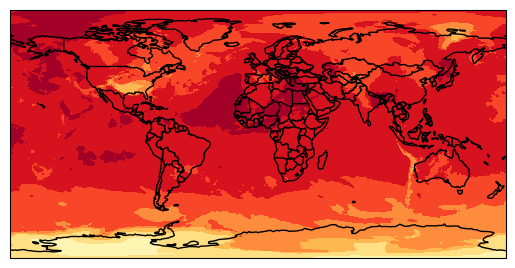

In [4]:
# 得到预测数据
# best_net.cpu()
best_net.eval()

predict_data = best_net(torch.tensor(features_normalized.astype(np.float32)).to(device))
preds_denormalized = test_label_scaler.inverse_transform(predict_data.cpu().detach().numpy())
df = pd.DataFrame({
    'Predicted': preds_denormalized.flatten(),  
})
df.to_csv('predictions.csv', index=False)

# 绘制地图
data_proj = ccrs.PlateCarree()
# ccrs

xx,yy,zz = lon,lat,preds_denormalized.reshape(1801,3600)
res = '50m'
fig = plt.figure(4)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN.with_scale(res), edgecolor='black')
ax.add_feature(cfeature.LAND.with_scale(res), edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='black')
ax.coastlines()
ax.contourf(xx,yy,zz,
                transform=data_proj,
                cmap='YlOrRd')
ax.set_global()
#ax.scatter(x, y, marker='o', transform=data_proj)
plt.show()